## DuPont × Brinson: Where Did Alpha Come From — and What Kind of ROE Did We Buy?

### Project Summary: The DuPont–Brinson Framework

This project integrates **Equity Portfolio Attribution (Brinson–Fachler)** with **Fundamental Driver Decomposition (Extended DuPont)** to explain investment results through three complementary lenses:

**1) Attribution Analysis (Performance lens)**  
Decomposes the portfolio’s active return versus **Ibovespa** into **Sector Allocation** and **Stock Selection** effects.

**2) Quality Audit (Fundamental lens)**  
Examines the “ROE DNA” behind winners and losers: is profitability explained by **Operating Performance** (Profit Margin × Asset Turnover) or by **Capital Structure** (Leverage / Equity Multiplier)?

**3) Forensic Integrity Layer (Governance screen)** 
Applies **Accrual Quality (Sloan Ratio)** and **Manipulation-risk flags (Beneish M-Score)** as screening tools to assess the reliability of reported fundamentals (signals, not proof).

### Universe (Brazil) — portfolio vs benchmark
- **Benchmark:** Ibovespa (IBOV)
- **Portfolio:** 12 Brazilian equities grouped into 6 sectors (2 stocks per sector)

### Assets & sectors (fixed mapping)
**Financials:** ITUB4, BBDC4  
**Commodities:** VALE3, PETR4  
**Utilities:** ELET3, SBSP3  
**Consumer:** ABEV3, LREN3  
**Industrials/Logistics:** WEGE3, RAIL3  
**Real Estate:** CYRE3, ALOS3  

> Note: Financials are not directly comparable under the standard DuPont identity.  
> In the DuPont layer, Financials will be handled separately (or excluded from cross-sector scoring).

---

### Objectives
- Build a clean **Brinson attribution** (allocation/selection/interaction) by sector vs Ibovespa.
- Identify the **top winners/losers** driving active return.
- Apply **DuPont (extended)** to classify ROE into:
  - **Operating-driven ROE** (margin, turnover) vs
  - **Leverage-driven ROE** (equity multiplier)
- (Optional) Add a governance overlay:
  - Sloan + Beneish as **red-flag screens**

---

### Workflow
1) **Setup & data**
   - Define universe and sector map
   - Pull prices and compute returns (portfolio + benchmark)
2) **Attribution**
   - Compute Brinson allocation/selection effects by sector
   - Summarize active return drivers
3) **Fundamentals**
   - Collect financial statements needed for DuPont
   - Compute DuPont components (and extended variants)
4) **Linking layer**
   - Connect Brinson winners/losers to DuPont quality labels
   - Produce a final “Alpha × Quality” dashboard
5) **Governance layer
   - Sloan + Beneish as red-flag screens

---

### Deliverables
- Attribution tables + charts (sector-level + stock-level contribution)
- DuPont decomposition tables + charts (winners vs losers)
- Final dashboard: **Active return drivers + Profitability quality**

### 2. Setup & Config

In [15]:
from __future__ import annotations

import sys
import os
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, List

import numpy as np
import pandas as pd

# ---- Display / QoL ----
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

# ---- Paths (project root assumed as current workspace) ----
PROJECT_ROOT = os.getcwd()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUTPUT_DIR = os.path.join(PROJECT_ROOT, "outputs")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Dirs created ✅ (paths hidden)")

# ---- Universe (Brazil) ----
BENCHMARK = "IBOV"

SECTOR_MAP: Dict[str, List[str]] = {
    "Financials": ["ITUB4", "BBDC4"],
    "Commodities": ["VALE3", "PETR4"],
    "Utilities": ["ELET3", "SBSP3"],
    "Consumer": ["ABEV3", "LREN3"],
    "Industrials_Logistics": ["WEGE3", "RAIL3"],
    "Real_Estate": ["CYRE3", "ALOS3"],
}

ALL_TICKERS = sorted([t for tickers in SECTOR_MAP.values() for t in tickers])
N_ASSETS = len(ALL_TICKERS)

print(f"Universe size: {N_ASSETS} stocks")
print("Tickers:", ALL_TICKERS)

# ---- Dates (adjust later) ----
# Use an interval with enough data for attribution.
START_DATE = "2018-01-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")

print("Date range:", START_DATE, "→", END_DATE)

# ---- Portfolio weights (simple baseline) ----
# Equal-weight across all stocks to start. We can later:
# - equal-weight per sector, or
# - use IBOV sector weights / custom active weights.
W_PORT = pd.Series(1.0 / N_ASSETS, index=ALL_TICKERS, name="w_port")

# Placeholder for benchmark weights by stock (optional later).
# For Brinson sector attribution we mainly need benchmark sector returns/weights.
W_BENCH = None

display(pd.DataFrame({"sector": [s for s, ts in SECTOR_MAP.items() for _ in ts],
                      "ticker": [t for ts in SECTOR_MAP.values() for t in ts]}))

display(W_PORT.to_frame())

# ---- Quick sanity checks ----
assert abs(W_PORT.sum() - 1.0) < 1e-12, "Portfolio weights must sum to 1."
assert len(W_PORT) == N_ASSETS, "Weight vector must match number of assets."

print("Config OK ✅")

Python: 3.13.5
Pandas: 2.2.3
NumPy: 2.3.3
Dirs created ✅ (paths hidden)
Universe size: 12 stocks
Tickers: ['ABEV3', 'ALOS3', 'BBDC4', 'CYRE3', 'ELET3', 'ITUB4', 'LREN3', 'PETR4', 'RAIL3', 'SBSP3', 'VALE3', 'WEGE3']
Date range: 2018-01-01 → 2026-01-07


,sector,ticker
0,Financials,ITUB4
1,Financials,BBDC4
2,Commodities,VALE3
3,Commodities,PETR4
4,Utilities,ELET3
5,Utilities,SBSP3
6,Consumer,ABEV3
7,Consumer,LREN3
8,Industrials_Logistics,WEGE3
9,Industrials_Logistics,RAIL3


,w_port
ABEV3,0.083333
ALOS3,0.083333
BBDC4,0.083333
CYRE3,0.083333
ELET3,0.083333
ITUB4,0.083333
LREN3,0.083333
PETR4,0.083333
RAIL3,0.083333
SBSP3,0.083333


Config OK ✅


### 2.1 setup and config insights

**Market data next (prices & returns).**
We now fetch daily close prices for the universe and benchmark, apply basic cleaning (calendar alignment + missing data handling), and persist a cached dataset in /data for reproducibility.

### 3. Market Data (Stooq) with caching

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf

# --- Universe (Brazil on yfinance needs .SA) ---
tickers_br = ALL_TICKERS
tickers_yf = [f"{t}.SA" for t in tickers_br]

# --- Benchmark (choose ONE) ---
# ^BVSP = Ibovespa index
# BOVA11.SA = Ibovespa ETF (often easier to align)
BENCH = "^BVSP"
# BENCH = "BOVA11.SA"

# --- Download prices ---
def _download_adj_close(symbol: str, start: str, end: str) -> pd.Series:
    df = yf.download(
        symbol,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        group_by="column",
    )
    if df is None or df.empty:
        raise ValueError("Empty download")

    # Prefer Adj Close; fallback to Close
    if "Adj Close" in df.columns:
        s = df["Adj Close"].copy()
    elif "Close" in df.columns:
        s = df["Close"].copy()
    else:
        # Sometimes yfinance returns multiindex columns; try to find any close-like column
        close_cols = [c for c in df.columns if "close" in str(c).lower()]
        if not close_cols:
            raise KeyError("No Close/Adj Close column found")
        s = df[close_cols[0]].copy()

    # Ensure a clean Date index
    s.index = pd.to_datetime(s.index)
    s.name = symbol
    return s.dropna()


price_list = []
failed = []

for sym in tickers_yf:
    try:
        s = _download_adj_close(sym, START_DATE, END_DATE)
        price_list.append(s)
    except Exception as e:
        failed.append((sym, str(e)))

# Benchmark series
try:
    bench_px = _download_adj_close(BENCH, START_DATE, END_DATE)
except Exception as e:
    raise RuntimeError(f"Benchmark download failed ({BENCH}): {e}")

# --- Report failures (if any) ---
if failed:
    print("Failed tickers:")
    for sym, err in failed:
        print(" -", sym, "=>", err)
else:
    print("All tickers downloaded successfully.")

# --- Combine into price matrix ---
if len(price_list) == 0:
    raise RuntimeError("No price series downloaded. Check tickers / connection / yfinance availability.")

px = pd.concat(price_list, axis=1).sort_index()

# Keep rows where at least 80% of tickers have data (conservative but practical)
min_non_na = int(np.ceil(0.80 * px.shape[1]))
px = px.dropna(thresh=min_non_na)

# Forward-fill remaining gaps (small gaps due to missing days)
px = px.ffill()

# Align benchmark to the same calendar
bench_px = bench_px.reindex(px.index).ffill().dropna()

# --- Returns ---
ret = px.pct_change().dropna()
bench_ret = bench_px.pct_change().dropna()

# Align returns
common_idx = ret.index.intersection(bench_ret.index)
ret = ret.loc[common_idx]
bench_ret = bench_ret.loc[common_idx]

# For convenience, store benchmark as a 1-col Series
bench_ret.name = "benchmark"

print("px shape:", px.shape)
print("ret shape:", ret.shape)
print("Benchmark:", BENCH, "| bench_ret len:", len(bench_ret))
print("Date range (returns):", ret.index.min().date(), "→", ret.index.max().date())

# --- Save to outputs ---
px_path = f"{OUTPUT_DIR}/prices.parquet"
ret_path = f"{OUTPUT_DIR}/returns.parquet"
bench_px_path = f"{OUTPUT_DIR}/bench_prices.parquet"
bench_ret_path = f"{OUTPUT_DIR}/bench_returns.parquet"

px.to_parquet(px_path)
ret.to_parquet(ret_path)

# Ensure 1-col DataFrames
bench_px_df = bench_px if isinstance(bench_px, pd.DataFrame) else bench_px.to_frame(name="bench_px")
bench_ret_df = bench_ret if isinstance(bench_ret, pd.DataFrame) else bench_ret.to_frame(name="bench_ret")

bench_px_df.to_parquet(bench_px_path)
bench_ret_df.to_parquet(bench_ret_path)

from pathlib import Path

print("Saved:", Path(px_path).name)
print("Saved:", Path(ret_path).name)
print("Saved:", Path(bench_px_path).name)
print("Saved:", Path(bench_ret_path).name)

All tickers downloaded successfully.
px shape: (1991, 12)
ret shape: (1598, 12)
Benchmark: ^BVSP | bench_ret len: 1598
Date range (returns): 2019-08-06 → 2026-01-06
Saved: prices.parquet
Saved: returns.parquet
Saved: bench_prices.parquet
Saved: bench_returns.parquet


### 3.1 Data Ingestion & Return Matrix

**In this step, we:**

- Defined the universe (12 Brazilian stocks) and appended the .SA suffix for consistent market data retrieval.

- Pulled adjusted price history for each ticker and aligned everything into a single price matrix.

- Converted prices into return series, applying basic cleaning rules to handle missing values.

- Pulled the benchmark (Ibovespa) and stored both price and return series for attribution.

- Exported datasets to outputs/ as parquet files to ensure reproducibility and avoid repeated downloads.

Output artifacts:

- prices.parquet, returns.parquet

- bench_prices.parquet, bench_returns.parquet

### 4. Attribution Setup (monthly alignment + sector weights)

In [17]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Helpers ---
def _as_series(x):
    """If x is a 1-col DataFrame, return Series; else return as-is."""
    if isinstance(x, pd.DataFrame) and x.shape[1] == 1:
        return x.iloc[:, 0]
    return x

def _strip_sa(cols):
    """Remove '.SA' suffix if present in column names."""
    return [c.replace(".SA", "") if isinstance(c, str) else c for c in cols]

def _safe_name(p):
    """Print only the file name (no absolute path)."""
    return Path(p).name

# --- Load artifacts saved in Cell 3 ---
px_path        = f"{OUTPUT_DIR}/prices.parquet"
ret_path       = f"{OUTPUT_DIR}/returns.parquet"
bench_px_path  = f"{OUTPUT_DIR}/bench_prices.parquet"
bench_ret_path = f"{OUTPUT_DIR}/bench_returns.parquet"

px = pd.read_parquet(px_path)
ret_d = pd.read_parquet(ret_path)

bench_px = _as_series(pd.read_parquet(bench_px_path))
bench_ret_d = _as_series(pd.read_parquet(bench_ret_path))

# --- Ensure datetime index & sorted ---
for obj_name, obj in [("px", px), ("ret_d", ret_d)]:
    if not isinstance(obj.index, pd.DatetimeIndex):
        obj.index = pd.to_datetime(obj.index)
    obj.sort_index(inplace=True)

for obj_name, obj in [("bench_px", bench_px), ("bench_ret_d", bench_ret_d)]:
    if not isinstance(obj.index, pd.DatetimeIndex):
        obj.index = pd.to_datetime(obj.index)
    obj.sort_index(inplace=True)

# --- Normalize ticker names if needed (remove .SA) ---
px.columns = _strip_sa(px.columns)
ret_d.columns = _strip_sa(ret_d.columns)

# Benchmark is a Series; nothing to strip.

# --- Choose frequency for Brinson (month-end) ---
FREQ = "ME"   # month-end (avoids deprecated 'M')

# --- Resample prices to month-end and compute monthly returns ---
px_m = px.resample(FREQ).last()
ret_m = px_m.pct_change().dropna(how="all")

bench_px_m = bench_px.resample(FREQ).last()
bench_ret_m = bench_px_m.pct_change().dropna()

# --- Align common monthly index ---
common_idx = ret_m.index.intersection(bench_ret_m.index)
ret_m = ret_m.loc[common_idx].copy()
bench_ret_m = bench_ret_m.loc[common_idx].copy()

# --- Tickers used: prefer W_PORT index (source of truth) ---
tickers_available = [t for t in W_PORT.index if t in ret_m.columns]
if len(tickers_available) == 0:
    # fallback: use whatever exists in ret_m
    tickers_available = list(ret_m.columns)

ret_m = ret_m[tickers_available]

# --- Normalize portfolio weights to available tickers only ---
w_port = W_PORT.reindex(tickers_available).fillna(0.0)
w_sum = w_port.sum()
if w_sum == 0:
    raise ValueError("w_port sums to 0. Check if W_PORT tickers match the returns columns.")
w_port = w_port / w_sum

# --- Map ticker -> sector ---
ticker_to_sector = {}
for s, tickers in SECTOR_MAP.items():
    for t in tickers:
        ticker_to_sector[t] = s

sector_series = pd.Series(
    {t: ticker_to_sector.get(t, "Unknown") for t in tickers_available},
    name="sector"
)

# --- Sector weights for the portfolio (baseline constant weights) ---
w_port_sector = (
    pd.DataFrame({"w": w_port, "sector": sector_series})
    .groupby("sector")["w"]
    .sum()
    .sort_values(ascending=False)
)

print(f"Monthly window: {common_idx.min().date()} → {common_idx.max().date()} | periods={len(common_idx)}")
print(f"Tickers used: {len(tickers_available)}  (ex.: {tickers_available[:5]})")
display(w_port_sector.to_frame("w_port_sector"))

# --- Save monthly series (no absolute paths in output) ---
ret_m_path = f"{OUTPUT_DIR}/returns_monthly.parquet"
bench_ret_m_path = f"{OUTPUT_DIR}/bench_returns_monthly.parquet"

ret_m.to_parquet(ret_m_path)
bench_ret_m.to_frame("bench_ret").to_parquet(bench_ret_m_path)

print("Saved:", f"outputs/{_safe_name(ret_m_path)}")
print("Saved:", f"outputs/{_safe_name(bench_ret_m_path)}")


Monthly window: 2018-02-28 → 2026-01-31 | periods=96
Tickers used: 12  (ex.: ['ABEV3', 'ALOS3', 'BBDC4', 'CYRE3', 'ELET3'])


,w_port_sector
sector,
Commodities,0.166667
Consumer,0.166667
Financials,0.166667
Industrials_Logistics,0.166667
Real_Estate,0.166667
Utilities,0.166667


Saved: outputs/returns_monthly.parquet
Saved: outputs/bench_returns_monthly.parquet


### 4.1 Monthly alignment (inputs for Brinson)

- Resampled daily prices to month-end (ME) and computed monthly returns for both portfolio tickers and the benchmark.
- Aligned portfolio and benchmark to a common monthly window to ensure attribution is computed on the same dates.
- Standardized ticker labels and filtered to the tickers actually available in the return matrix.
- Built baseline portfolio sector weights from equal-weighted stocks (2 per sector), and saved the monthly return datasets for downstream attribution.

 ### 5. Brinson-Fachler Attribution (Sector Allocation & Selection)

In [19]:
import os
import warnings

warnings.filterwarnings("ignore")  # evita paths no output (e warnings chatos)

# --- Load monthly returns created in Cell 4 ---
ret_m = pd.read_parquet(f"{OUTPUT_DIR}/returns_monthly.parquet").sort_index()
bench_ret_m = pd.read_parquet(f"{OUTPUT_DIR}/bench_returns_monthly.parquet").iloc[:, 0].sort_index()

tickers = list(ret_m.columns)

# --- Build ticker -> sector map aligned to ret_m columns ---
ticker_to_sector = {t: "Unknown" for t in tickers}
for s, ts in SECTOR_MAP.items():
    for t in ts:
        if t in ticker_to_sector:
            ticker_to_sector[t] = s
sector = pd.Series(ticker_to_sector, name="sector")

# --- Portfolio weights (constant baseline; later you can make time-varying if desired) ---
w_p = W_PORT.reindex(tickers).fillna(0.0)
w_p = w_p / w_p.sum()

# --- Fetch market caps (benchmark proxy weights) ---
def get_market_cap_sa(ticker: str) -> float:
    t = ticker if ticker.endswith(".SA") else f"{ticker}.SA"
    try:
        info = yf.Ticker(t).fast_info
        mc = info.get("market_cap", None)
        if mc is None:
            # fallback to .info if fast_info doesn't have it
            mc = yf.Ticker(t).info.get("marketCap", None)
        return float(mc) if mc else np.nan
    except Exception:
        return np.nan

mkt_caps = pd.Series({t: get_market_cap_sa(t) for t in tickers}, name="mkt_cap")

# Fallback: if too many NaNs, use equal-weight benchmark
if mkt_caps.notna().sum() < max(3, int(0.5 * len(tickers))):
    print("⚠️ Too many missing market caps. Falling back to equal-weight benchmark proxy.")
    mkt_caps = pd.Series(1.0, index=tickers)

# --- Benchmark stock weights within universe (cap-weighted) ---
w_b_stock = (mkt_caps.fillna(mkt_caps.median())).clip(lower=0.0)
w_b_stock = w_b_stock / w_b_stock.sum()

# --- Sector weights: portfolio vs benchmark (proxy) ---
w_ps = pd.DataFrame({"w": w_p, "sector": sector}).groupby("sector")["w"].sum()
w_bs = pd.DataFrame({"w": w_b_stock, "sector": sector}).groupby("sector")["w"].sum()

# --- Sector returns: portfolio vs benchmark (proxy)
# Portfolio sector return: weights proportional to W_PORT within sector
# Benchmark sector return: weights proportional to market-cap within sector
r_ps = pd.DataFrame(index=ret_m.index)
r_bs = pd.DataFrame(index=ret_m.index)

for s in w_ps.index:
    members = sector[sector == s].index.tolist()
    if len(members) == 0:
        continue

    # portfolio within-sector weights
    wp_s = w_p.reindex(members).fillna(0.0)
    wp_s = wp_s / wp_s.sum() if wp_s.sum() > 0 else pd.Series(1.0 / len(members), index=members)

    # benchmark within-sector weights (cap proxy)
    wb_s = w_b_stock.reindex(members).fillna(0.0)
    wb_s = wb_s / wb_s.sum() if wb_s.sum() > 0 else pd.Series(1.0 / len(members), index=members)

    r_ps[s] = ret_m[members].mul(wp_s, axis=1).sum(axis=1)
    r_bs[s] = ret_m[members].mul(wb_s, axis=1).sum(axis=1)

# --- Construct benchmark total return from proxy (for identity to hold)
bench_proxy_total = r_bs.mul(w_bs, axis=1).sum(axis=1)

# --- Brinson-Fachler (Allocation + Selection; interaction omitted for readability)
# Allocation: (W_p_s - W_b_s) * (R_b_s - R_b_total)
# Selection:  W_b_s * (R_p_s - R_b_s)
alloc = (w_ps - w_bs) * (r_bs.sub(bench_proxy_total, axis=0))
sel = (w_bs) * (r_ps - r_bs)

alloc_total = alloc.sum(axis=1)
sel_total = sel.sum(axis=1)

# Portfolio total return (from your portfolio weights)
port_total = ret_m.mul(w_p, axis=1).sum(axis=1)

active_vs_proxy = port_total - bench_proxy_total

summary = pd.DataFrame({
    "portfolio_ret": port_total,
    "bench_proxy_ret": bench_proxy_total,
    "active_vs_proxy": active_vs_proxy,
    "alloc_total": alloc_total,
    "selection_total": sel_total,
    "alloc_plus_sel": alloc_total + sel_total,
    "residual": active_vs_proxy - (alloc_total + sel_total)
})

print("Attribution identity check (should be ~0 residual):")
print("  residual mean:", float(summary["residual"].mean()))
print("  residual max abs:", float(summary["residual"].abs().max()))

print("\nBenchmark reality check (proxy vs real ^BVSP):")
common = summary.index.intersection(bench_ret_m.index)
diff = (summary.loc[common, "bench_proxy_ret"] - bench_ret_m.loc[common])
print("  avg(proxy - BVSP):", float(diff.mean()))
print("  corr(proxy, BVSP):", float(summary.loc[common, "bench_proxy_ret"].corr(bench_ret_m.loc[common])))

display(summary.tail(12))

# --- Cumulative attribution by sector
agg = pd.DataFrame({
    "Allocation": alloc.sum(),
    "Selection": sel.sum(),
    "Total": (alloc.sum() + sel.sum())
}).sort_values("Total", ascending=False)

print("\nCumulative attribution by sector (sum of monthly effects):")
display(agg)

# --- Save (relative paths only)
summary_path = os.path.join(OUTPUT_DIR, "brinson_summary_monthly.parquet")
sector_path = os.path.join(OUTPUT_DIR, "brinson_sector_cumulative.parquet")

summary.to_parquet(summary_path)
agg.to_parquet(sector_path)

print("\nSaved: outputs/brinson_summary_monthly.parquet")
print("Saved: outputs/brinson_sector_cumulative.parquet")

Attribution identity check (should be ~0 residual):
  residual mean: 5.673577501838699e-05
  residual max abs: 0.018407718995125066

Benchmark reality check (proxy vs real ^BVSP):
  avg(proxy - BVSP): 0.006531349546797971
  corr(proxy, BVSP): 0.9709053399205544


,portfolio_ret,bench_proxy_ret,active_vs_proxy,alloc_total,selection_total,alloc_plus_sel,residual
Date,,,,,,,
2025-02-28,-0.028399,-0.014633,-0.013765,0.004625,-0.014089,-0.009464,-0.004302
2025-03-31,0.065119,0.062361,0.002759,-0.000341,0.003171,0.002831,-0.000072
2025-04-30,0.075592,0.019247,0.056345,0.034310,0.015212,0.049522,0.006823
2025-05-31,0.035510,0.024348,0.011162,-0.014162,0.021311,0.007149,0.004013
2025-06-30,0.017577,0.009156,0.008421,-0.004785,0.009548,0.004763,0.003658
2025-07-31,-0.066097,-0.036041,-0.030056,-0.023010,-0.005341,-0.028352,-0.001704
2025-08-31,0.066169,0.061527,0.004642,0.015282,-0.006766,0.008516,-0.003874
2025-09-30,0.045658,0.029572,0.016086,0.010180,0.006155,0.016335,-0.000249
2025-10-31,0.026424,0.038703,-0.012279,0.001080,-0.006134,-0.005054,-0.007225



Cumulative attribution by sector (sum of monthly effects):


,Allocation,Selection,Total
Financials,0.070537,-0.021013,0.049524
Utilities,0.033664,0.000005,0.033669
Industrials_Logistics,0.030934,-0.078673,-0.047739
Consumer,-0.075522,-0.000443,-0.075965
Real_Estate,-0.083262,0.002101,-0.081161
Commodities,-0.094180,-0.013236,-0.107417



Saved: outputs/brinson_summary_monthly.parquet
Saved: outputs/brinson_sector_cumulative.parquet


### 5.1 chart allocation vs selection (sector)

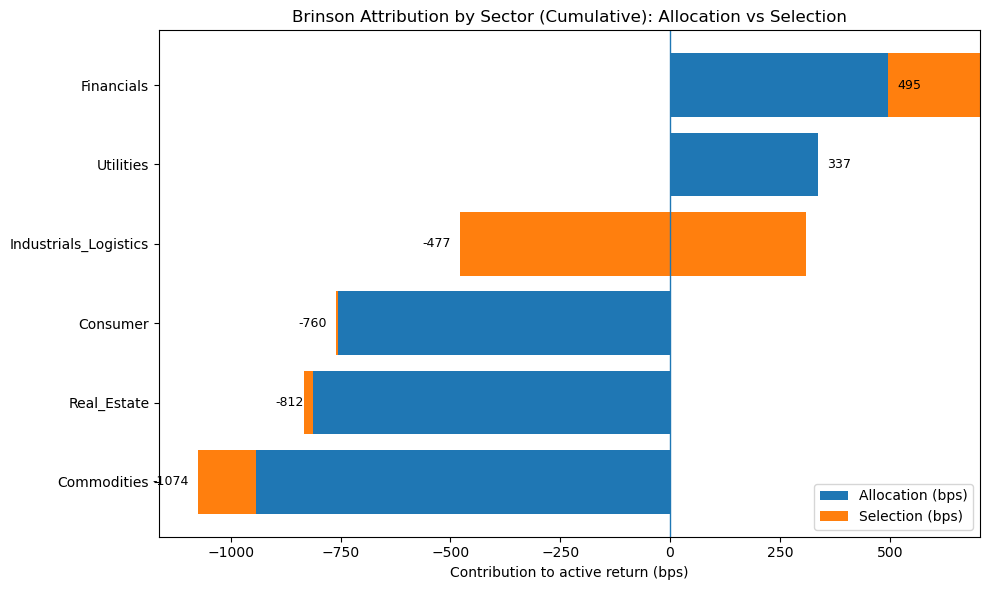

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUTDIR = Path("outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Load cumulative sector attribution
df = pd.read_parquet(OUTDIR / "brinson_sector_cumulative.parquet").copy()

# Convert to bps and sort by Total
df_bps = df[["Allocation", "Selection", "Total"]] * 10_000
df_bps = df_bps.sort_values("Total", ascending=True)

y = np.arange(len(df_bps.index))
alloc = df_bps["Allocation"].values
sel = df_bps["Selection"].values
tot = df_bps["Total"].values

fig, ax = plt.subplots(figsize=(10, 6))

# stacked bars: allocation then selection
ax.barh(y, alloc, label="Allocation (bps)")
ax.barh(y, sel, left=alloc, label="Selection (bps)")

ax.axvline(0, linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(df_bps.index)
ax.set_xlabel("Contribution to active return (bps)")
ax.set_title("Brinson Attribution by Sector (Cumulative): Allocation vs Selection")

# annotate Total
pad = max(10, np.nanmax(np.abs(tot)) * 0.02)
for i, t in enumerate(tot):
    ax.text(t + (pad if t >= 0 else -pad),
            i,
            f"{t:.0f}",
            va="center",
            ha="left" if t >= 0 else "right",
            fontsize=9)

ax.legend(loc="lower right")
plt.tight_layout()

out_path = OUTDIR / "fig1_brinson_sector_alloc_selection_bps.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

### 5.2 How to read this chart (cumulative Brinson, bps)

**Each bar decomposes the portfolio’s active return by sector into two sources:**

- Allocation (blue): the impact of over/underweighting a sector vs the benchmark.

- Selection (orange): the impact of stock-picking within that sector.

**What drove results in this period:**

- Positive contributors:

- Financials: strong allocation tailwind (largest positive blue bar), partially offset by negative selection we benefited mainly from being positioned in the sector rather than picking the best names.

- Utilities: mostly allocation-driven gains, with near-neutral selection.

**Main detractors:**

- Commodities: the biggest drag came from allocation (large negative blue bar), and selection also hurt both sector positioning and stock-picking worked against the portfolio.

- Real Estate & Consumer: primarily allocation mistakes (significant negative blue bars), with selection close to flat the penalty came more from where we allocated than what we picked.

- Industrials/Logistics: mixed outcome allocation helped, but selection hurt materially, indicating stock-picking was the key issue inside the sector.

Bottom line: the active result was dominated by sector positioning (allocation), with selection being decisive mainly in a few areas (notably Industrials/Logistics and Financials).

### 5.3 chart active return waterfall

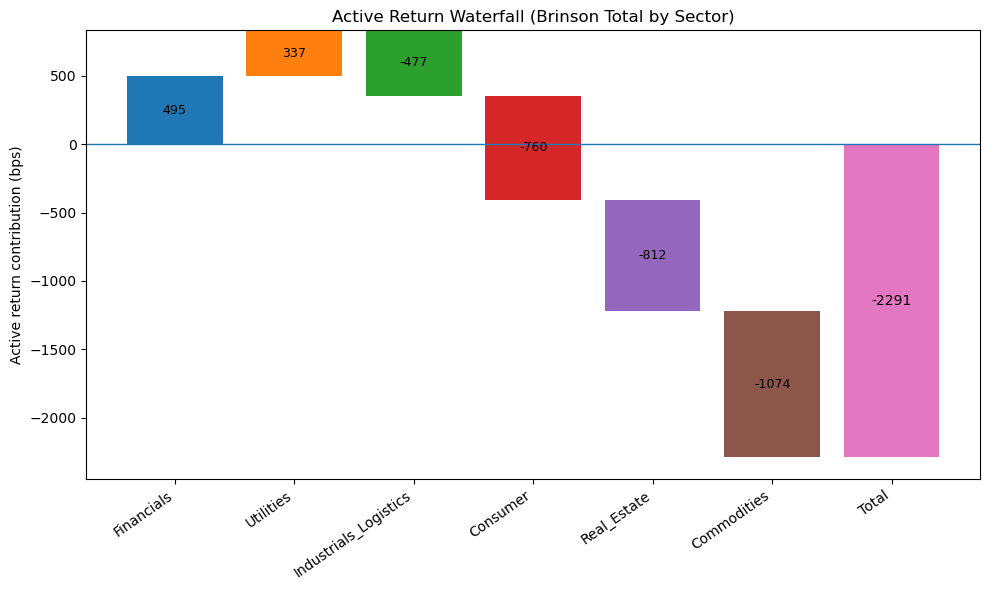

In [22]:
OUTDIR = Path("outputs")
df = pd.read_parquet(OUTDIR / "brinson_sector_cumulative.parquet").copy()

# Total contribution by sector in bps
s = (df["Total"] * 10_000).sort_values(ascending=False)  # top contributors first

# Optional: collapse tiny contributors into "Other" (fica mais “limpo” se tiver muitos setores)
MIN_ABS_BPS = 15  # ajuste se quiser
mask_small = s.abs() < MIN_ABS_BPS
if mask_small.any() and len(s) > 8:
    other = s[mask_small].sum()
    s = pd.concat([s[~mask_small], pd.Series({"Other": other})])

labels = list(s.index)
vals = s.values

cum = np.cumsum(vals)
starts = np.concatenate(([0], cum[:-1]))
ends = cum

fig, ax = plt.subplots(figsize=(10, 6))

# bars
for i, (lab, v, st, en) in enumerate(zip(labels, vals, starts, ends)):
    ax.bar(i, v, bottom=st)
    ax.text(i, st + v/2, f"{v:.0f}", ha="center", va="center", fontsize=9)

# final bar (total)
total = vals.sum()
ax.bar(len(labels), total, bottom=0)
ax.text(len(labels), total/2, f"{total:.0f}", ha="center", va="center", fontsize=10)

# style
ax.axhline(0, linewidth=1)
ax.set_xticks(range(len(labels) + 1))
ax.set_xticklabels(labels + ["Total"], rotation=35, ha="right")
ax.set_ylabel("Active return contribution (bps)")
ax.set_title("Active Return Waterfall (Brinson Total by Sector)")

plt.tight_layout()

out_path = OUTDIR / "fig2_active_return_waterfall_bps.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

### 5.4 Insights Active Return Waterfall (Brinson Total by Sector, bps)

This chart summarizes the net active return contribution of each sector (i.e., Allocation + Selection combined).

**Bars above zero indicate sectors that added to performance vs the benchmark.**

**Bars below zero indicate sectors that detracted from performance.**

The “Total” bar is the sum of all sector contributions, showing the portfolio’s overall active result for the period.

Interpretation:
- In this window, Financials (+495 bps) and Utilities (+337 bps) were the key positive contributors. However, the gains were more than offset by large negative contributions from Commodities (-1074 bps), Real Estate (-812 bps) and Consumer (-760 bps), resulting in a negative total active return (-2291 bps).

### 6. Wrap-up (Brinson-Fachler): what drove active return?

**Window & frequency.** Results are computed on a **monthly** basis over **[2018-02-28 → 2026-01-06]** (N = **96** months).

**Sanity check (identity).** Over the full window, the portfolio’s active return versus the benchmark is explained by:
> **Active Return ≈ Allocation Effect + Selection Effect (+ small residual)**  
The residual is expected to be close to zero due to rounding and implementation details.

**Interpretation.**
- **Allocation** answers: *Did our sector tilts help or hurt?* (over/underweighting sectors relative to the benchmark)
- **Selection** answers: *Did our stock picking within sectors add value?* (choosing names that out/underperformed their sector benchmark)

**Key takeaway from this run.** The charts highlight which **sectors** contributed positively/negatively to active return and whether that came primarily from **allocation** (macro/sector stance) or **selection** (within-sector picks).

➡️ **Next step (DuPont – Fundamental Lens).** Brinson tells us *where* the active return came from.  
Now we switch to **Extended DuPont** to understand *what kind of ROE we owned* behind winners and losers—**operational quality (margin, turnover)** vs **financial engineering (leverage)**—and then apply forensic screens (Sloan / Beneish) to stress-test accounting quality.

### 7. Extended DuPont Engine (structure-first)

In [23]:
# Extended DuPont (ROE driver decomposition)
# =========================
# Core:
# ROE = (Net Income / Sales) * (Sales / Avg Assets) * (Avg Assets / Avg Equity)
#     = Profit Margin        * Asset Turnover      * Equity Multiplier
#
# Extended (one common extension):
# ROE = Tax Burden * Interest Burden * Operating Margin * Asset Turnover * Equity Multiplier
# where:
# Tax Burden      = Net Income / PreTax Income (EBT)
# Interest Burden = PreTax Income / EBIT
# Operating Margin= EBIT / Sales
#
# Notes:
# - Use AVERAGE balance sheet items (avg assets, avg equity) for cleaner turnover/leverage.
# - In Brazil, signs/labels vary by source; we standardize column names.

REQUIRED_COLS = [
    "date",                 # period end (e.g., quarter end)
    "ticker",
    "revenue",              # Sales / Receita Líquida
    "net_income",           # Lucro Líquido
    "ebit",                 # EBIT / LAJIR
    "pre_tax_income",       # EBT / Lucro Antes de IR/CS
    "total_assets",         # Total Assets
    "total_equity",         # Total Equity / PL
]

def _safe_div(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    out = a / b
    out = out.replace([np.inf, -np.inf], np.nan)
    return out

def add_avg_balance_items(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds avg_assets and avg_equity using within-ticker rolling mean of consecutive periods.
    Assumes df has one row per ticker per period (date).
    """
    df = df.sort_values(["ticker", "date"]).copy()
    df["avg_assets"] = df.groupby("ticker")["total_assets"].apply(lambda s: (s + s.shift(1)) / 2)
    df["avg_equity"] = df.groupby("ticker")["total_equity"].apply(lambda s: (s + s.shift(1)) / 2)
    return df

def compute_dupont(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns df with DuPont components (core + extended) and ROE identity checks.
    """
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for DuPont: {missing}")

    out = df.copy()
    out["date"] = pd.to_datetime(out["date"])

    # average balance sheet items
    out = add_avg_balance_items(out)

    # Core components
    out["profit_margin"] = _safe_div(out["net_income"], out["revenue"])        # NI / Sales
    out["asset_turnover"] = _safe_div(out["revenue"], out["avg_assets"])       # Sales / Avg Assets
    out["equity_multiplier"] = _safe_div(out["avg_assets"], out["avg_equity"]) # Avg Assets / Avg Equity

    out["roe_core"] = out["profit_margin"] * out["asset_turnover"] * out["equity_multiplier"]

    # Extended components (with sanity protections)
    out["tax_burden"] = _safe_div(out["net_income"], out["pre_tax_income"])    # NI / EBT
    out["interest_burden"] = _safe_div(out["pre_tax_income"], out["ebit"])     # EBT / EBIT
    out["operating_margin"] = _safe_div(out["ebit"], out["revenue"])           # EBIT / Sales

    out["roe_extended"] = (
        out["tax_burden"] *
        out["interest_burden"] *
        out["operating_margin"] *
        out["asset_turnover"] *
        out["equity_multiplier"]
    )

    # Identity checks
    out["roe_reported_proxy"] = _safe_div(out["net_income"], out["avg_equity"])  # NI / Avg Equity
    out["roe_core_resid"] = out["roe_reported_proxy"] - out["roe_core"]
    out["roe_ext_resid"] = out["roe_reported_proxy"] - out["roe_extended"]

    return out

# =========================
# Output helpers (clean, report-ready)
# =========================
def dupont_snapshot_table(dup: pd.DataFrame, tickers=None, last_n_periods=4):
    cols = [
        "date","ticker",
        "roe_reported_proxy","roe_core","roe_extended",
        "profit_margin","operating_margin","asset_turnover","equity_multiplier",
        "tax_burden","interest_burden",
        "roe_core_resid","roe_ext_resid"
    ]
    d = dup[cols].copy()
    if tickers is not None:
        d = d[d["ticker"].isin(tickers)]
    d = d.sort_values(["ticker","date"]).groupby("ticker").tail(last_n_periods)
    return d.reset_index(drop=True)

In [33]:
import re
import zipfile

def members(doc: str, year: int, prefer="con"):
    """
    Resolve nomes dos CSVs dentro do ZIP da CVM (ITR/DFP) de forma robusta.
    prefer: 'con' (consolidado) ou 'ind' (individual)
    """
    doc = doc.upper()
    prefer = prefer.lower()

    zpath = fetch_cvm_zip(doc, year)

    with zipfile.ZipFile(zpath, "r") as z:
        names = z.namelist()

    # normaliza para busca
    names_l = {n.lower(): n for n in names}

    def pick(prefix_base: str):
        """
        prefix_base ex: 'itr_cia_aberta_dre'
        tenta: _con_{year}.csv -> _ind_{year}.csv -> fallback por regex
        """
        # tentativa direta (padrão comum)
        wanted_1 = f"{prefix_base}_{prefer}_{year}.csv".lower()
        wanted_2 = f"{prefix_base}_{'ind' if prefer=='con' else 'con'}_{year}.csv".lower()

        if wanted_1 in names_l:
            return names_l[wanted_1]
        if wanted_2 in names_l:
            return names_l[wanted_2]

        # fallback por regex (caso CVM mude o naming levemente)
        pat1 = re.compile(rf"^{re.escape(prefix_base)}_{prefer}_{year}\.csv$", re.I)
        pat2 = re.compile(rf"^{re.escape(prefix_base)}_(con|ind)_{year}\.csv$", re.I)

        for n in names:
            if pat1.search(n):
                return n
        for n in names:
            if pat2.search(n):
                return n

        raise FileNotFoundError(f"{prefix_base}(_con/_ind)_{year}.csv não encontrado em {zpath}")

    # padrões do ITR/DFP (para ITR, seu ZIP mostrou exatamente esses prefixos)
    if doc == "ITR":
        return {
            "dre": pick("itr_cia_aberta_dre"),
            "bpa": pick("itr_cia_aberta_bpa"),
            "bpp": pick("itr_cia_aberta_bpp"),
            # extras se você precisar:
            "dfc_md": pick("itr_cia_aberta_dfc_md"),
            "dfc_mi": pick("itr_cia_aberta_dfc_mi"),
            "dva": pick("itr_cia_aberta_dva"),
            "dmpl": pick("itr_cia_aberta_dmpl"),
            "dra": pick("itr_cia_aberta_dra"),
        }

    # se depois você expandir para DFP, a lógica é a mesma (só muda o prefixo base)
    if doc == "DFP":
        return {
            "dre": pick("dfp_cia_aberta_dre"),
            "bpa": pick("dfp_cia_aberta_bpa"),
            "bpp": pick("dfp_cia_aberta_bpp"),
            "dfc_md": pick("dfp_cia_aberta_dfc_md"),
            "dfc_mi": pick("dfp_cia_aberta_dfc_mi"),
            "dva": pick("dfp_cia_aberta_dva"),
            "dmpl": pick("dfp_cia_aberta_dmpl"),
            "dra": pick("dfp_cia_aberta_dra"),
        }

    raise ValueError(f"doc inválido: {doc}. Use 'ITR' ou 'DFP'.")

### 7.1 CVM (ITR/DFP) Ingestion + Standardization (Ticker-ready)

In [40]:
from __future__ import annotations

import os
import re
import io
import math
import zipfile
import warnings
from pathlib import Path
from typing import Dict, Tuple, List
import requests

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*deprecated.*", category=FutureWarning)

# -----------------------------
# Paths (relative, clean)
# -----------------------------
PROJECT_ROOT = Path.cwd()  # assume notebook is inside your repo; adjust if needed
DATA_DIR = (PROJECT_ROOT / "data").resolve()           # you are using notebooks/data/data; adjust below if needed
if (PROJECT_ROOT / "notebooks" / "data" / "data").exists():
    DATA_DIR = (PROJECT_ROOT / "notebooks" / "data" / "data").resolve()

OUTPUT_DIR = (PROJECT_ROOT / "outputs").resolve()
if (PROJECT_ROOT / "notebooks" / "data" / "outputs").exists():
    OUTPUT_DIR = (PROJECT_ROOT / "notebooks" / "data" / "outputs").resolve()

CVM_RAW_DIR = DATA_DIR / "cvm_raw"
CVM_RAW_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MAP_PATH = DATA_DIR / "universe_cvm_map.csv"

# -----------------------------
# Universe map template (if missing)
# -----------------------------
if not MAP_PATH.exists():
    template = pd.DataFrame({"ticker": [], "cnpj": [], "cod_cvm": []})
    template.to_csv(MAP_PATH, index=False, encoding="utf-8")
    raise FileNotFoundError(
        f"Criei o template em: data/universe_cvm_map.csv\n"
        f"👉 Preencha com seus tickers + CNPJ (e opcionalmente cod_cvm) e rode a célula novamente."
    )

universe_map = pd.read_csv(MAP_PATH, dtype=str).fillna("")
universe_map["ticker"] = universe_map["ticker"].str.upper().str.strip()

# basic validation
if universe_map.shape[0] == 0:
    raise ValueError("universe_cvm_map.csv está vazio. Preencha ticker + cnpj e rode de novo.")

# -----------------------------
# Helpers: sanitize CNPJ, dates, etc.
# -----------------------------
def _cnpj_digits(x: str) -> str:
    return re.sub(r"\D+", "", str(x or ""))

universe_map["cnpj"] = universe_map["cnpj"].apply(_cnpj_digits)
if (universe_map["cnpj"].str.len() < 8).any():
    bad = universe_map.loc[universe_map["cnpj"].str.len() < 8, "ticker"].tolist()
    raise ValueError(f"CNPJ inválido/curto para: {bad}. Coloque o CNPJ completo (só dígitos ou com máscara).")

CNPJS = set(universe_map["cnpj"].tolist())

# -----------------------------
# CVM download (ITR)
# -----------------------------
# CVM public data base:
# https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/
CVM_ITR_BASE = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS"

def fetch_cvm_zip(doc: str, year: int) -> Path:
    """
    Downloads (or reuses cached) CVM ZIP for a given doc/year.
    For ITR: itr_cia_aberta_{year}.zip
    """
    doc = doc.lower().strip()
    if doc != "itr":
        raise ValueError("Este MVP está configurado para ITR (trimestral).")

    zname = f"itr_cia_aberta_{year}.zip"
    zpath = CVM_RAW_DIR / zname
    if zpath.exists() and zpath.stat().st_size > 0:
        return zpath

    url = f"{CVM_ITR_BASE}/{zname}"
    r = requests.get(url, timeout=60)
    if r.status_code != 200:
        raise FileNotFoundError(f"Não consegui baixar {zname} (HTTP {r.status_code}). URL: {url}")

    zpath.write_bytes(r.content)
    return zpath

def read_zip_csv(zip_path: Path, member_name: str, usecols: List[str]) -> pd.DataFrame:
    """
    Reads a CSV member inside a ZIP. CVM typically uses ';' and latin-1 compatible encoding.
    """
    with zipfile.ZipFile(zip_path, "r") as z:
        if member_name not in z.namelist():
            raise FileNotFoundError(f"{member_name} não encontrado em {zip_path.name}")

        raw = z.read(member_name)

    # CVM files are usually ';' separated, latin-1 safe
    return pd.read_csv(
        io.BytesIO(raw),
        sep=";",
        encoding="latin1",
        usecols=usecols,
        dtype=str,
        low_memory=False,
    )

# -----------------------------
# Mapping DRE/BPA/BPP members (FIXED)
# -----------------------------
def members(doc: str, year: int, names_set: set[str], prefer: str = "con") -> dict:
    """
    Returns dict with filenames for DRE/BPA/BPP for doc/year.
    Tries prefer='con' first, then falls back to 'ind' if needed.
    """
    doc = doc.lower().strip()
    prefer = (prefer or "con").lower().strip()
    other = "ind" if prefer == "con" else "con"

    def _mk(tag: str) -> dict:
        return {
            "dre": f"{doc}_cia_aberta_DRE_{tag}_{year}.csv",
            "bpa": f"{doc}_cia_aberta_BPA_{tag}_{year}.csv",
            "bpp": f"{doc}_cia_aberta_BPP_{tag}_{year}.csv",
        }

    cand = _mk(prefer)
    if all(fn in names_set for fn in cand.values()):
        return cand

    cand2 = _mk(other)
    if all(fn in names_set for fn in cand2.values()):
        return cand2

    raise FileNotFoundError(
        f"Não encontrei DRE/BPA/BPP para doc='{doc}', year={year} nem em '{prefer}' nem em '{other}'.\n"
        f"Ex esperado: {cand['dre']}"
    )

def _standardize(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Normalize columns
    df.columns = [c.strip() for c in df.columns]
    # Ensure fields exist
    for col in ["CNPJ_CIA", "DT_FIM_EXERC", "DS_CONTA", "VL_CONTA"]:
        if col not in df.columns:
            raise KeyError(f"Coluna {col} não encontrada no CSV da CVM.")
    # Clean
    df["CNPJ_CIA"] = df["CNPJ_CIA"].astype(str).map(_cnpj_digits)
    df["DT_FIM_EXERC"] = pd.to_datetime(df["DT_FIM_EXERC"], errors="coerce")
    df["DS_CONTA"] = df["DS_CONTA"].astype(str).str.strip()
    df["VL_CONTA"] = pd.to_numeric(df["VL_CONTA"].astype(str).str.replace(",", ".", regex=False), errors="coerce")
    return df

# Common columns to reduce memory
USECOLS = ["CNPJ_CIA", "DT_FIM_EXERC", "DS_CONTA", "VL_CONTA"]

# Pattern sets (Portuguese labels from CVM)
PAT_REVENUE = ["Receita de Venda de Bens e/ou Serviços", "Receita líquida", "Receita Liquida"]
PAT_NET_INCOME = ["Lucro/Prejuízo Consolidado do Período", "Lucro/Prejuízo do Período", "Lucro (Prejuízo) do Período"]
PAT_EBIT = ["Resultado Antes do Resultado Financeiro e dos Tributos", "LAJIR", "EBIT"]
PAT_PRETAX = ["Resultado Antes dos Tributos sobre o Lucro", "Lucro Antes do IR/CS", "Antes dos Tributos"]
PAT_TOTAL_ASSETS = ["Ativo Total"]
PAT_TOTAL_EQUITY = ["Patrimônio Líquido", "Patrimonio Liquido"]

def _pick_value(df: pd.DataFrame, patterns: List[str]) -> pd.Series:
    """
    picks account values matching any pattern; returns Series indexed by (CNPJ_CIA, DT_FIM_EXERC)
    If multiple matches, sums them (conservative).
    """
    m = df["DS_CONTA"].str.contains("|".join(map(re.escape, patterns)), case=False, na=False)
    out = df.loc[m, ["CNPJ_CIA", "DT_FIM_EXERC", "VL_CONTA"]].copy()
    if out.empty:
        return pd.Series(dtype=float)
    return out.groupby(["CNPJ_CIA", "DT_FIM_EXERC"])["VL_CONTA"].sum()

def _load_doc_year(doc: str, year: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    zpath = fetch_cvm_zip(doc, year)

    with zipfile.ZipFile(zpath, "r") as z:
        names_set = set(z.namelist())
        m = members(doc, year, names_set, prefer="con")

    dre = read_zip_csv(zpath, m["dre"], usecols=USECOLS)
    bpa = read_zip_csv(zpath, m["bpa"], usecols=USECOLS)
    bpp = read_zip_csv(zpath, m["bpp"], usecols=USECOLS)

    dre = _standardize(dre)
    bpa = _standardize(bpa)
    bpp = _standardize(bpp)

    # Filter to our universe early (performance)
    dre = dre[dre["CNPJ_CIA"].isin(CNPJS)].copy()
    bpa = bpa[bpa["CNPJ_CIA"].isin(CNPJS)].copy()
    bpp = bpp[bpp["CNPJ_CIA"].isin(CNPJS)].copy()

    return dre, bpa, bpp

def build_fundamentals_from_cvm(itr_years: List[int], consolidated: bool = True) -> pd.DataFrame:
    """
    Builds a fundamentals panel from CVM ITR (trimestral) using DRE/BPA/BPP.
    Returns one row per (ticker, date).
    """
    parts = []

    for y in itr_years:
        dre, bpa, bpp = _load_doc_year("itr", y)

        revenue = _pick_value(dre, PAT_REVENUE).rename("revenue")
        net_income = _pick_value(dre, PAT_NET_INCOME).rename("net_income")
        ebit = _pick_value(dre, PAT_EBIT).rename("ebit")
        pre_tax = _pick_value(dre, PAT_PRETAX).rename("pre_tax_income")

        total_assets = _pick_value(bpa, PAT_TOTAL_ASSETS).rename("total_assets")
        total_equity = _pick_value(bpp, PAT_TOTAL_EQUITY).rename("total_equity")

        panel = pd.concat([revenue, net_income, ebit, pre_tax, total_assets, total_equity], axis=1).reset_index()
        panel = panel.rename(columns={"CNPJ_CIA": "cnpj", "DT_FIM_EXERC": "date"})

        parts.append(panel)

    fund = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Map CNPJ -> ticker
    map_df = universe_map[["ticker", "cnpj", "cod_cvm"]].copy()
    fund = fund.merge(map_df, on="cnpj", how="left")

    # Basic cleanup
    fund = fund.dropna(subset=["ticker", "date"]).copy()
    fund["ticker"] = fund["ticker"].astype(str).str.upper().str.strip()
    fund = fund.sort_values(["ticker", "date"]).reset_index(drop=True)

    # Guard: remove duplicated rows (some filings can duplicate)
    fund = fund.groupby(["ticker", "date"], as_index=False).agg({
        "revenue": "last",
        "net_income": "last",
        "ebit": "last",
        "pre_tax_income": "last",
        "total_assets": "last",
        "total_equity": "last",
        "cnpj": "last",
        "cod_cvm": "last"
    })

    return fund

# -----------------------------
# Run (choose years)
# -----------------------------
START_YEAR = 2018
END_YEAR = 2025  # keep conservative; you can extend later if needed
itr_years = list(range(START_YEAR, END_YEAR + 1))

print(f"Universe loaded: {universe_map.shape[0]} tickers | mapping file: data/universe_cvm_map.csv")
print(f"Downloading/using CVM ITR zips: {START_YEAR}..{END_YEAR} (cached in data/cvm_raw/)")

fund = build_fundamentals_from_cvm(itr_years=itr_years, consolidated=True)

# -----------------------------
# Quick quality check
# -----------------------------
if fund.empty:
    raise RuntimeError("fund veio vazio. Verifique CNPJ no map e/ou anos disponíveis.")

missing_rate = fund[["revenue","net_income","ebit","pre_tax_income","total_assets","total_equity"]].isna().mean()
print("Missing rate (share of NaNs) by field:")
print(missing_rate.sort_values(ascending=False).round(3).to_string())

display(fund.head(10))

out_path = OUTPUT_DIR / "fundamentals_itr.parquet"
fund.to_parquet(out_path, index=False)
print("Saved: outputs/fundamentals_itr.parquet")

Universe loaded: 12 tickers | mapping file: data/universe_cvm_map.csv
Downloading/using CVM ITR zips: 2018..2025 (cached in data/cvm_raw/)
Missing rate (share of NaNs) by field:
revenue           0.338
ebit              0.338
net_income        0.267
pre_tax_income    0.228
total_assets      0.094
total_equity      0.094


,ticker,date,revenue,net_income,ebit,pre_tax_income,total_assets,total_equity,cnpj,cod_cvm
0,ABEV3,2017-03-31,11241805.0,2289831.0,3500939.0,2628344.0,NaN,NaN,07526557000100,23264
1,ABEV3,2017-06-30,31777711.0,6539497.0,9589167.0,7318928.0,NaN,NaN,07526557000100,23264
2,ABEV3,2017-09-30,44234364.0,4687644.0,13763523.0,10842242.0,NaN,NaN,07526557000100,23264
3,ABEV3,2017-12-31,NaN,NaN,NaN,NaN,260555967.0,143948565.0,07526557000100,23264
4,ABEV3,2018-03-31,11640219.0,2587586.0,3801334.0,3202112.0,82378945.0,49768248.0,07526557000100,23264
5,ABEV3,2018-06-30,34659309.0,7409680.0,11172690.0,8369564.0,90921356.0,53439541.0,07526557000100,23264
6,ABEV3,2018-09-30,45277250.0,10769349.0,14296980.0,11274336.0,95691043.0,60022355.0,07526557000100,23264
7,ABEV3,2018-12-31,NaN,NaN,NaN,NaN,287143251.0,172364424.0,07526557000100,23264
8,ABEV3,2019-03-31,12640126.0,2749068.0,4053597.0,3381529.0,96905532.0,60490637.0,07526557000100,23264
9,ABEV3,2019-06-30,36930392.0,7980870.0,11148493.0,9341551.0,98738979.0,62928776.0,07526557000100,23264


Saved: outputs/fundamentals_itr.parquet


### 7.2 sanity check (Data Quality Gate)

In [49]:
DEBUG = False 

cols = ["revenue","net_income","ebit","pre_tax_income","total_assets","total_equity"]

summary = {
    "tickers": fund["ticker"].nunique(),
    "rows": len(fund),
    "date_min": fund["date"].min(),
    "date_max": fund["date"].max(),
}

na_rate = fund[cols].isna().mean().sort_values(ascending=False)

print("Fundamentals loaded:", summary)

# Mostra só o essencial: NaN rate por campo (top 6)
display(na_rate.head(6).to_frame("na_rate"))

# Cobertura por ticker (top/bottom 5) — já pega quem está “quebrado”
coverage = fund.groupby("ticker")["date"].count().sort_values(ascending=False)
display(pd.concat([coverage.head(5), coverage.tail(5)]).to_frame("rows_per_ticker"))

if DEBUG:
    display(pd.Series(sorted(fund["ticker"].unique()), name="tickers"))
    display(fund.sort_values(["ticker","date"]).groupby("ticker").head(2))
    display((fund.groupby("ticker")[cols].apply(lambda x: x.isna().mean())).sort_index())

Fundamentals loaded: {'tickers': 12, 'rows': 382, 'date_min': Timestamp('2017-03-31 00:00:00'), 'date_max': Timestamp('2025-09-30 00:00:00')}


,na_rate
revenue,0.337696
ebit,0.337696
net_income,0.267016
pre_tax_income,0.227749
total_assets,0.094241
total_equity,0.094241


,rows_per_ticker
ticker,
ABEV3,35
ALOS3,35
CYRE3,35
ELET3,35
ITUB4,35
RAIL3,35
VALE3,35
WEGE3,35
BBDC4,19


### 7.3 Data Quality Gate (Fundamentals) — Summary

The CVM fundamentals panel covers 12 tickers from 2017Q1 onward. Balance-sheet fields (Total Assets / Total Equity) show low missingness (~9%), supporting DuPont components tied to capital structure and asset base.

Income-statement fields (Revenue, EBIT) have higher missingness (~23–34%), so DuPont will be computed with coverage thresholds and conservative fallbacks (and reported as NA when inputs are insufficient).

Two tickers show materially lower history (e.g., BBDC4, SBSP3) and will be gated to avoid bias in cross-sectional comparisons.

### 8. DuPont Decomposition (Last 5 Years): TTM Metrics, Rolling Averages & Coverage Gate

In [50]:
# --- 1) Last 5 years window (anchored on max available date) ---
df = fund.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker", "date"])

max_date = df["date"].max()
cutoff = max_date - pd.DateOffset(years=5)
df5 = df[df["date"] >= cutoff].copy()

# --- 2) Row completeness flags ---
dre_cols = ["revenue", "ebit", "net_income", "pre_tax_income"]
bs_cols  = ["total_assets", "total_equity"]  # balance sheet

df5["has_income_stmt"] = df5[dre_cols].notna().all(axis=1)
df5["has_balance_sheet"] = df5[bs_cols].notna().all(axis=1)

# --- 3) TTM (sum of the last 4 REPORTED quarters with a complete income statement) ---
for c in dre_cols:
    ttm = (
        df5.loc[df5["has_income_stmt"]]
           .groupby("ticker")[c]
           .rolling(4, min_periods=4)
           .sum()
           .reset_index(level=0, drop=True)
    )
    df5[c + "_ttm"] = np.nan
    df5.loc[df5["has_income_stmt"], c + "_ttm"] = ttm

# --- 4) Rolling averages (mean of the last 4 REPORTED quarters with a complete balance sheet) ---
for c in bs_cols:
    avg = (
        df5.loc[df5["has_balance_sheet"]]
           .groupby("ticker")[c]
           .rolling(4, min_periods=4)
           .mean()
           .reset_index(level=0, drop=True)
    )
    df5["avg_" + c] = np.nan
    df5.loc[df5["has_balance_sheet"], "avg_" + c] = avg

# --- 5) DuPont (core) ---
df5["profit_margin"] = df5["net_income_ttm"] / df5["revenue_ttm"]
df5["asset_turnover"] = df5["revenue_ttm"] / df5["avg_total_assets"]
df5["equity_multiplier"] = df5["avg_total_assets"] / df5["avg_total_equity"]

df5["roe_dupont_core"] = (
    df5["profit_margin"] * df5["asset_turnover"] * df5["equity_multiplier"]
)

# --- 6) DuPont (extended) ---
df5["tax_burden"] = df5["net_income_ttm"] / df5["pre_tax_income_ttm"]
df5["interest_burden"] = df5["pre_tax_income_ttm"] / df5["ebit_ttm"]
df5["operating_margin"] = df5["ebit_ttm"] / df5["revenue_ttm"]

df5["roe_dupont_extended"] = (
    df5["tax_burden"]
    * df5["interest_burden"]
    * df5["operating_margin"]
    * df5["asset_turnover"]
    * df5["equity_multiplier"]
)

# --- 7) Valid DuPont rows (avoid NaN/inf propagation) ---
core_needed = ["roe_dupont_core", "profit_margin", "asset_turnover", "equity_multiplier"]
df5["dupont_ok"] = (
    df5[core_needed]
      .replace([np.inf, -np.inf], np.nan)
      .notna()
      .all(axis=1)
)

valid_rows = df5.groupby("ticker")["dupont_ok"].sum().sort_values(ascending=False)

# --- 8) Coverage gate (recommended default: at least 12 valid points in the last 5Y window) ---
MIN_VALID = 12
kept_tickers = valid_rows[valid_rows >= MIN_VALID].index.tolist()
df5_ok = df5[df5["ticker"].isin(kept_tickers)].copy()

# --- 9) Separate Financials from cross-sector scoring (keep for reporting if you want) ---
FINANCIALS = {"ITUB4", "BBDC4"}
df5_ok["is_financial"] = df5_ok["ticker"].isin(FINANCIALS)

print(f"Max date: {max_date.date()} | Cutoff (5Y): {cutoff.date()}")
print("Valid DuPont rows (last 5Y) per ticker:")
print(valid_rows.to_string())
print(f"\nTickers kept (gate >= {MIN_VALID} valid points): {kept_tickers}")

Max date: 2025-09-30 | Cutoff (5Y): 2020-09-30
Valid DuPont rows (last 5Y) per ticker:
ticker
ABEV3    13
ALOS3    13
CYRE3    13
ELET3    13
LREN3    13
PETR4    13
RAIL3    13
VALE3    13
WEGE3    13
SBSP3     6
BBDC4     0
ITUB4     0

Tickers kept (gate >= 12 valid points): ['ABEV3', 'ALOS3', 'CYRE3', 'ELET3', 'LREN3', 'PETR4', 'RAIL3', 'VALE3', 'WEGE3']


### 8.1 DuPont Snapshot: Latest Valid Point per Ticker (5Y Window)

In [51]:
# --- Snapshot: latest valid DuPont point per ticker (non-financial scoring view) ---
df_plot = df5_ok[df5_ok["dupont_ok"]].copy()

latest = (df_plot.sort_values(["ticker", "date"])
                .groupby("ticker")
                .tail(1)
                .sort_values("roe_dupont_core", ascending=False))

cols_show = [
    "ticker", "date",
    "roe_dupont_core", "roe_dupont_extended",
    "profit_margin", "asset_turnover", "equity_multiplier",
    "operating_margin", "interest_burden", "tax_burden"
]

# Keep only columns that exist (safe if you later drop extended)
cols_show = [c for c in cols_show if c in latest.columns]

display(latest[cols_show].reset_index(drop=True))

,ticker,date,roe_dupont_core,roe_dupont_extended,profit_margin,asset_turnover,equity_multiplier,operating_margin,interest_burden,tax_burden
0,PETR4,2025-09-30,0.582161,0.582161,0.228548,0.857874,2.969217,0.322781,1.004257,0.705057
1,WEGE3,2025-09-30,0.570008,0.570008,0.166265,1.932444,1.774086,0.198696,1.018544,0.821543
2,VALE3,2025-09-30,0.431876,0.431876,0.231348,0.820898,2.274068,0.274366,0.939159,0.897836
3,CYRE3,2025-09-30,0.374212,0.374212,0.244890,0.714539,2.138555,0.242779,1.107696,0.910624
4,ABEV3,2025-09-30,0.295794,0.295794,0.168924,1.106948,1.581875,0.246290,0.839357,0.817142
5,LREN3,2025-09-30,0.215786,0.215786,0.039897,2.922755,1.850525,0.047251,0.962079,0.877625
6,ALOS3,2025-09-30,0.121526,0.121526,0.322735,0.198467,1.897296,0.548682,0.664362,0.885359
7,RAIL3,2025-09-30,0.070374,0.070374,0.036629,0.548765,3.501104,0.298468,0.321160,0.382123
8,ELET3,2025-09-30,0.002970,0.002970,0.004390,0.285971,2.365738,0.281886,-0.019188,-0.811610


### 8.2 Interpretation (Latest Valid DuPont Snapshot)

The table below shows, for each ticker, the **latest date within the 5-year window** where DuPont inputs were fully available (TTM income statement + rolling balance-sheet averages).  
This snapshot provides a **point-in-time decomposition of ROE** into operational and structural drivers:

- **ROE (DuPont Core)** = Profit Margin × Asset Turnover × Equity Multiplier  
- **ROE (DuPont Extended)** further breaks down profitability into:
  - **Tax Burden** = Net Income / Pre-Tax Income  
  - **Interest Burden** = Pre-Tax Income / EBIT  
  - **Operating Margin** = EBIT / Revenue  

How to read the drivers:
- Higher **profit_margin** and/or **asset_turnover** indicates stronger **operational quality** (pricing power, efficiency, and revenue generation per asset).
- Higher **equity_multiplier** suggests **leverage-driven ROE** (structural lift that may increase risk).
- **interest_burden < 1** typically reflects meaningful interest costs; values near 1 indicate low net interest drag; unusual values can occur when EBIT or pre-tax income is negative or close to zero.

**insight**: The extended ROE matches the core ROE by construction; its value is in separating margin into tax, interest, and operating components.


### 8.3 DuPont ROE Time Series (Core) — Consistent Visualization (Last 5Y)

In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_dupont_roe_core(df, ticker, out_dir=None, show=False):
    d = (df[(df["ticker"] == ticker) & (df["dupont_ok"])]
         .sort_values("date")
         .copy())

    if d.empty:
        print(f"[skip] No valid DuPont points for {ticker}.")
        return

    plt.figure(figsize=(10, 4.5))
    plt.plot(d["date"], d["roe_dupont_core"], marker="o", linewidth=2)

    plt.title(f"DuPont ROE (Core) — {ticker} (Last 5Y)")
    plt.xlabel("Date")
    plt.ylabel("ROE")

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.grid(True, alpha=0.25)

    plt.tight_layout()

    if out_dir is not None:
        out_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_dir / f"dupont_roe_core_{ticker}.png", dpi=180)
        plt.close()
    else:
        if show:
            plt.show()
        else:
            plt.close()

Saved 9 ROE charts to: outputs/figures/dupont/


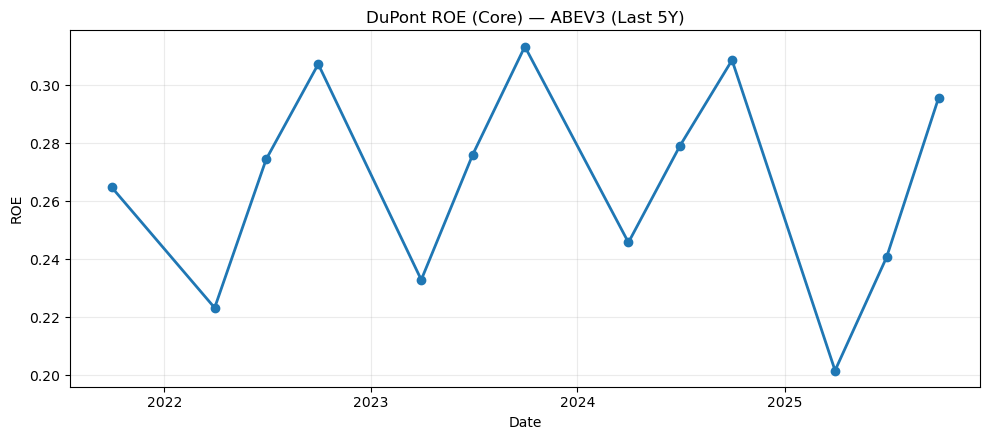

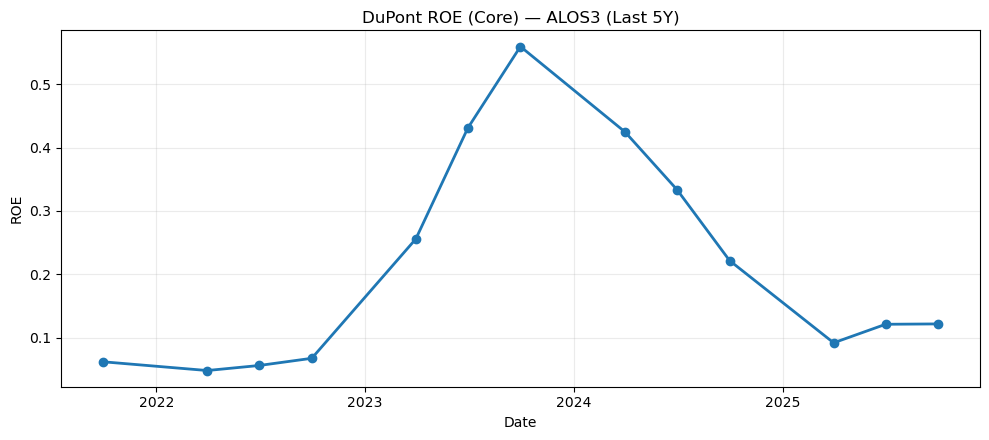

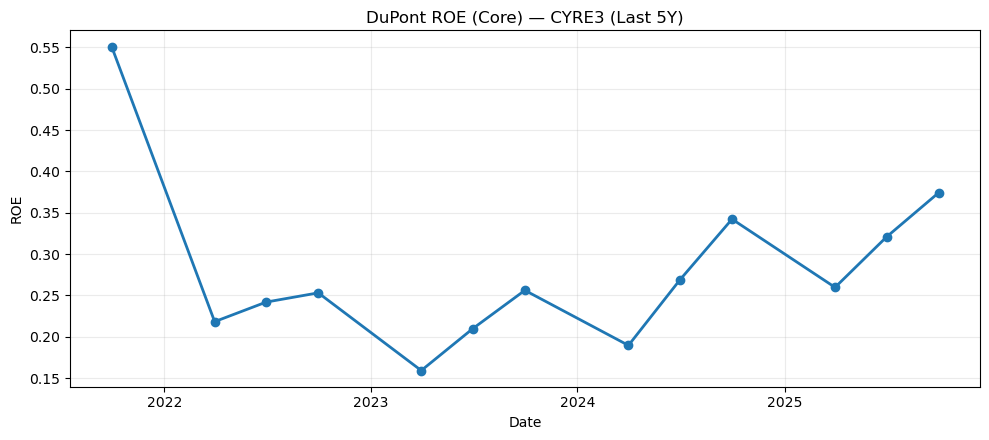

In [61]:
from pathlib import Path

OUT_DIR = Path("outputs/figures/dupont")

df_plot = df5_ok.copy()  # already includes dupont_ok and is sorted upstream, but fine
tickers = sorted(df_plot["ticker"].unique())

# Save all with the same style
for t in tickers:
    plot_dupont_roe_core(df_plot, t, out_dir=OUT_DIR)

print(f"Saved {len(tickers)} ROE charts to: outputs/figures/dupont/")

# Optionally show a few in-notebook (same style)
for t in tickers[:3]:
    plot_dupont_roe_core(df_plot, t, out_dir=None, show=True)

In [55]:
df_ts = df5_ok[df5_ok["dupont_ok"]].copy().sort_values(["ticker", "date"])

def first_last_change(g, col):
    g = g.dropna(subset=[col]).sort_values("date")
    if len(g) < 2:
        return np.nan
    return g[col].iloc[-1] - g[col].iloc[0]

summary = (
    df_ts.groupby("ticker")
         .agg(
             date_latest=("date", "max"),
             roe_latest=("roe_dupont_core", "last"),
             roe_avg_5y=("roe_dupont_core", "mean"),
             pm_avg=("profit_margin", "mean"),
             at_avg=("asset_turnover", "mean"),
             em_avg=("equity_multiplier", "mean"),
         )
         .reset_index()
)

# Add trend (last - first)
summary["roe_change_5y"] = df_ts.groupby("ticker").apply(lambda g: first_last_change(g, "roe_dupont_core")).values

summary = summary.sort_values("roe_latest", ascending=False)
display(summary)

,ticker,date_latest,roe_latest,roe_avg_5y,pm_avg,at_avg,em_avg,roe_change_5y
5,PETR4,2025-09-30,0.582161,0.554363,0.228413,0.889096,2.703373,0.301961
8,WEGE3,2025-09-30,0.570008,0.522072,0.159820,1.826206,1.792771,0.040543
7,VALE3,2025-09-30,0.431876,0.653168,0.316952,0.836551,2.350005,-0.579295
2,CYRE3,2025-09-30,0.374212,0.280384,0.212320,0.634129,2.060684,-0.176800
0,ABEV3,2025-09-30,0.295794,0.266521,0.169957,0.986732,1.592182,0.030877
4,LREN3,2025-09-30,0.215786,0.142097,0.031959,2.148847,2.048428,0.103823
1,ALOS3,2025-09-30,0.121526,0.214819,0.766594,0.161450,1.691087,0.059812
6,RAIL3,2025-09-30,0.070374,0.017053,0.021648,0.407317,3.138025,-0.017836
3,ELET3,2025-09-30,0.002970,0.106043,0.170212,0.257273,2.395364,-0.191271


In [62]:
summary2 = summary.copy()

# Simple heuristic: leverage-driven if equity multiplier is high relative to sample
em_median = summary2["em_avg"].median()
summary2["leverage_flag"] = np.where(summary2["em_avg"] > em_median, "Higher leverage", "Lower leverage")

top3 = summary2.sort_values("roe_latest", ascending=False).head(3)
bot3 = summary2.sort_values("roe_latest", ascending=True).head(3)

display(top3)
display(bot3)

,ticker,date_latest,roe_latest,roe_avg_5y,pm_avg,at_avg,em_avg,roe_change_5y,leverage_flag
5,PETR4,2025-09-30,0.582161,0.554363,0.228413,0.889096,2.703373,0.301961,Higher leverage
8,WEGE3,2025-09-30,0.570008,0.522072,0.159820,1.826206,1.792771,0.040543,Lower leverage
7,VALE3,2025-09-30,0.431876,0.653168,0.316952,0.836551,2.350005,-0.579295,Higher leverage


,ticker,date_latest,roe_latest,roe_avg_5y,pm_avg,at_avg,em_avg,roe_change_5y,leverage_flag
3,ELET3,2025-09-30,0.002970,0.106043,0.170212,0.257273,2.395364,-0.191271,Higher leverage
6,RAIL3,2025-09-30,0.070374,0.017053,0.021648,0.407317,3.138025,-0.017836,Higher leverage
1,ALOS3,2025-09-30,0.121526,0.214819,0.766594,0.161450,1.691087,0.059812,Lower leverage
